<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/18-reinforcement-learning/1_introduction_to_open_ai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to OpenAI Gym

One of the challenges of Reinforcement Learning is that in order to train an agent, you first need to have a working environment. If you want to program an agent that will learn to play an Atari game, you will need an Atari game simulator. If you want to program a walking robot, then the environment is the real world, and you can directly train your robot in that environment, 

But this has its limits: if the robot falls off a cliff, you can’t just click Undo. You can’t speed up time either; adding more computing power won’t make the robot move any faster. And it’s generally too expensive to train 1,000 robots in parallel. In short, training is hard and slow in the real world,
so you generally need a simulated environment at least for bootstrap training.

[OpenAI Gym](https://gym.openai.com/) is a toolkit that provides a wide variety of simulated environments (Atari games, board games, 2D and 3D physical simulations, and so on), so you can train agents, compare them, or develop new RL algorithms.

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

## Introduction to OpenAI gym

OpenAI gym, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with. Let's start by importing gym:

In [0]:
import gym

Let's list all the available environments:

In [0]:
gym.envs.registry.all()

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [0]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is reset() method. This returns an observation:

In [6]:
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its render() method, and you can pick the rendering mode (the rendering options depend on the environment).

> **Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify mode="rgb_array". In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. 

On Debian or Ubuntu:

```python
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the xvfb-run command:

```python
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```python
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [7]:
try:
  import pyvirtualdisplay
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
  pass

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [8]:
env.render()

True

In this example we will set mode="rgb_array" to get an image of the environment as a NumPy array:

In [9]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [0]:
def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

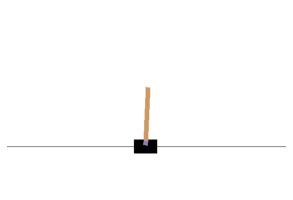

In [11]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). 

Let’s ask the environment what actions are possible:

In [14]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [15]:
action = 1   # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

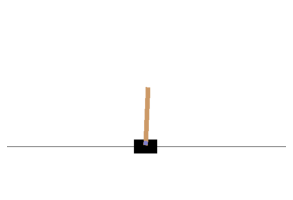

In [17]:
plot_environment(env)
plt.show()

Looks like it's doing what we're telling it to do!

The step() method executes the given action and returns four values:

* **obs** : This is the new observation. The cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

* **reward**: In this environment, you get a reward of 1.0 at every step, no matter what you do, so the goal is to keep the episode running as long as possible.

* **done**: This value will be True when the episode is over. This will happen when the pole tilts too much, or goes off the screen, or after 200 steps (in this last case, you have won). After that, the environment must be reset before it can be used again.

* **info**: This environment-specific dictionary can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [18]:
# The environment also tells the agent how much reward it got during the last step
reward

1.0

In [19]:
# When the game is over, the environment returns done=True
done

False

In [20]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when step() returns done=True), you should reset the environment before you continue to use it.

In [0]:
if done:
  obs = env.reset()

Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

## A simple hard-coded policy

Let’s hardcode a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right. We will run this policy to see the average rewards it gets over 500 episodes:

In [0]:
env.seed(42)

def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [23]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [0]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [26]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

Let’s see if a neural network can come up with a better policy.

## Neural Network Policies